In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.ddpg.td3 as td3

import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import itertools
%matplotlib inline

import pandas as pd
from multiprocessing import Pool
from itertools import product
from seagul.plot import smooth_bounded_curve
import os
import time

jup_dir = "/home/sgillen/work/"

/home/sgillen/work/seagul/seagul/envs/__init__.py:49: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")


2020-04-09 17:19:29,280	INFO resource_spec.py:212 -- Starting Ray with 5.03 GiB memory available for workers and up to 2.53 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-09 17:19:29,601	INFO services.py:1148 -- View the Ray dashboard at localhost:8265
2020-04-09 17:19:29,792	INFO trainer.py:428 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-04-09 17:19:29,868	WARNING deprecation.py:30 -- DeprecationWarning: `sample_batch_size` has been deprecated. Use `rollout_fragment_length` instead. This will raise an error in the future!
2020-04-09 17:19:29,869	INFO trainer.py:585 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-04-09 17:19:33,130	INFO trainable.py:217 -- Getting current IP.
2020-04-09 17:19:33,199	INFO trainable.py:217 -- Getting current IP.
2020-04-09 17:19:33,200	INFO trainable.py:423 -- Restored on 1

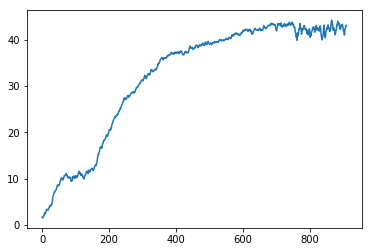

(pid=19519) /home/sgillen/work/seagul/seagul/envs/__init__.py:49: UserWarning: Warning, pybullet envs not installed
(pid=19519)   warnings.warn("Warning, pybullet envs not installed")


In [2]:
checkpoint_path = jup_dir + \
"lorenz/data/tune/euler_but_working/PPO/PPO_linear_z-v0_3a87e5d2_2020-02-20_23-31-52h5407qju/checkpoint_910/checkpoint-910"
config_path =  '/'.join(checkpoint_path.split('/')[:-2]) + '/params.pkl'
config = dill.load(open(config_path, 'rb'))
env_name = config['env']

csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
df = pd.read_csv(csv_path)
plt.plot(df['episode_reward_mean'])


ray.shutdown()
ray.init()

trainer = ppo.PPOTrainer(config)#, config['env_name'])
#trainer = td3.TD3Trainer(config)
#trainer = ddpg.DDPGTrainer(config)
#trainer = sac.SACTrainer(config)

trainer.restore(checkpoint_path)

(<matplotlib.figure.Figure at 0x7f36215cb6d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f34e6f53c50>)

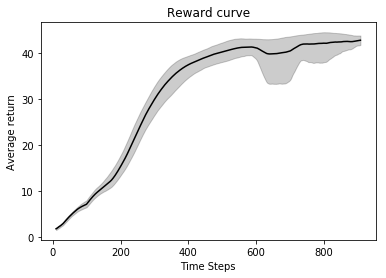

In [4]:
directory = jup_dir + \
"/lorenz/data/tune/euler_but_working/PPO"

df_list = []

for i, entry in enumerate(os.scandir(directory)):
    try:
        df_list.append(pd.read_csv(entry.path + "/progress.csv"))
    except FileNotFoundError:
        pass

rewards = np.zeros((df_list[0]['episode_reward_mean'].shape[0], len(df_list)))

for i, df in enumerate(df_list):
    rewards[:, i] = df['episode_reward_mean']

smooth_bounded_curve(rewards)

In [5]:
def do_rollout(init_point):
    env = gym.make(env_name, **config['env_config'])
    obs = env.reset(init_point)

    action_hist = []
    m_act_hist = []
    obs_hist = []
    reward_hist = []

    done = False

    while not done:
        actions, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
        obs, reward, done, _ = env.step(np.asarray(actions))

        action_hist.append(np.copy(actions))
        obs_hist.append(np.copy(obs))
        reward_hist.append(np.copy(reward))


    action_hist = np.stack(action_hist)
    obs_hist = np.stack(obs_hist)
    reward_hist = np.stack(reward_hist)
    
    return obs_hist, action_hist, reward_hist


def do_det_rollout(init_point):
    env = gym.make(env_name, **config['env_config'])
    obs = env.reset(init_point)
    obs[-1] = -10.0

    action_hist = []
    m_act_hist = []
    obs_hist = []
    reward_hist = []

    done = False

    while not done:
        sampled_actions, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
        actions = out_dict['behaviour_logits'][0:2]

        obs, reward, done, _ = env.step(np.asarray(actions))
        action_hist.append(np.copy(actions))
        obs_hist.append(np.copy(obs))
        reward_hist.append(np.copy(reward))


    action_hist = np.stack(action_hist)
    obs_hist = np.stack(obs_hist)
    reward_hist = np.stack(reward_hist)
    
    return obs_hist, action_hist, reward_hist

# Rollouts

440.0


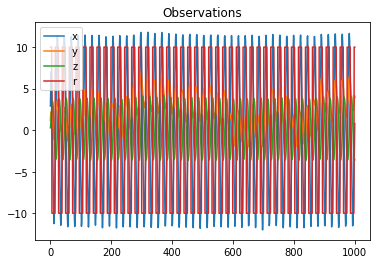

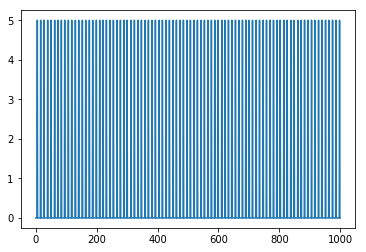

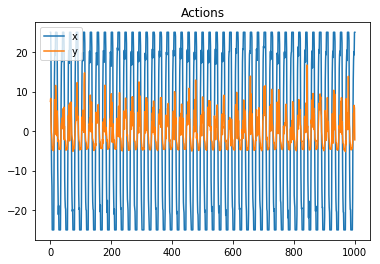

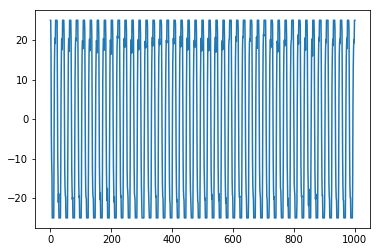

In [6]:
X0 = np.array([-27.2586,    6.5937,  -16.9758])
X0 = np.array([1, 1,.3])
config['env_config']['num_steps'] = 1000
obs_hist, action_hist, reward_hist = do_rollout(init_point = np.random.random(3))
print(sum(reward_hist))

plt.plot(obs_hist)
plt.title('Observations')
plt.legend(['x', 'y', 'z', 'r'])

plt.figure()
plt.plot(reward_hist)

plt.figure()
plt.plot(action_hist)
plt.legend(['x', 'y'])
plt.title('Actions')

plt.figure()
plt.plot(action_hist[:,0])


Text(0.5, 0.92, 'phase diagram')

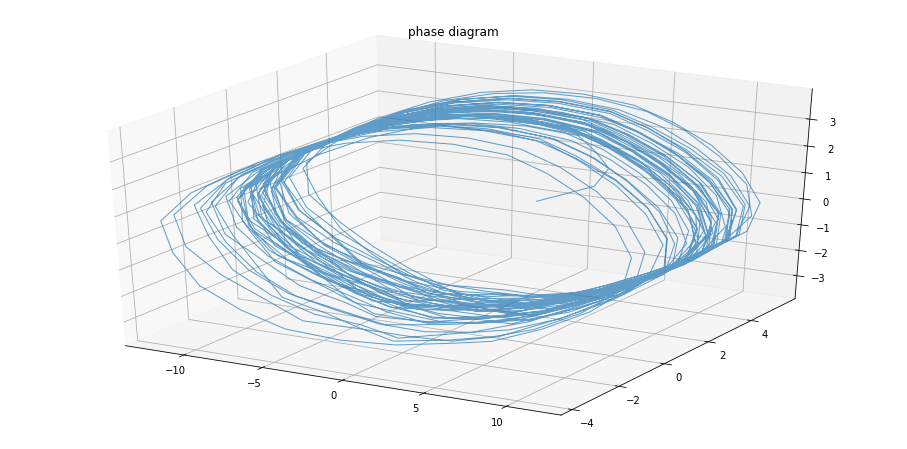

In [6]:
obs_arr = np.stack(obs_hist)

x = obs_arr[:,0]; y = obs_arr[:,1]; z = obs_arr[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram')

# Local Point Analysis

In [7]:
num_steps = config['env_config']['num_steps']
config['env_config']['num_steps'] = 5000
obs_hist, _ , _ = do_rollout(np.array([0,0,0]))
limit_set = obs_hist[4900:,:]
config['env_config']['num_steps'] = num_steps

In [8]:
seed_point = np.array(obs_hist[-1,:3])
dx = dy = dz = 1e-6

deltas = itertools.product([-dx, dx, 0], [-dy, dy, 0], [-dz, dz, 0])
deltas = np.array(list(deltas))

init_points = seed_point + deltas

final_points = np.zeros_like(init_points)
min_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], config['env_config']['num_steps']+1, init_points.shape[1]))

trainer.get_policy().cur_noise_scale = 0.0

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist = do_rollout(init_point)
    trajs[i,:] = obs_hist[:,:3]

KeyboardInterrupt: 

In [ ]:
num_trajs = trajs.shape[0]

min_x = np.zeros((num_trajs, num_steps))
min_y = np.zeros((num_trajs, num_steps))
min_z = np.zeros((num_trajs, num_steps))
min_d = np.zeros((num_trajs, num_steps))
min_d = np.zeros((num_trajs, num_steps))
min_dxz = np.zeros((num_trajs, num_steps))

for i in range(trajs.shape[0]):
    for t in range(num_steps):
        min_x[i,t] = np.min(np.linalg.norm((trajs[i,t,0] - limit_set[:,0]).reshape(1,-1),axis=0))
        min_y[i,t] = np.min(np.linalg.norm((trajs[i,t,1] - limit_set[:,1]).reshape(1,-1),axis=0))
        min_z[i,t] = np.min(np.linalg.norm((trajs[i,t,2] - limit_set[:,2]).reshape(1,-1),axis=0))
        min_d[i,t] = np.min(np.linalg.norm(trajs[i,t,:] - limit_set[:,:3], axis=1))
        min_dxz[i,t] = np.min(np.linalg.norm(trajs[i,t,0::2] - limit_set[:,0::2], axis=1))

In [ ]:
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,0])
    plt.title("X trajectories, d* = " + str(dx))
    
plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,1])
    plt.title("Y trajectories, d* = " + str(dy))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,2])
    plt.title("Z trajectories, d* = " + str(dz))

In [ ]:
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_d[i,:])
    plt.title("Euclidean distance from nominal, d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_dxz[i,:])
    plt.title("Euclidean distance excluding Y from nominal, d* = " + str(dx))
    
plt.figure()    
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_x[i,:])
    plt.title("X distance from nominal , d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_y[i,:])
    plt.title("Y distance from nominal , d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_z[i,:])
    plt.title("Z distance from nominal, d* = " + str(dx))

# Global point analysis

In [9]:
num_points = int(1e3)
config["env_config"]["num_steps"] = 1000

init_points = np.random.uniform(low = np.array([-10,-10,-10]), high = np.array([10, 10, 10]), size=(num_points,3))
final_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], config["env_config"]["num_steps"]+1, init_points.shape[1]))

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist = do_rollout(init_point)
    trajs[i,:] = obs_hist[:,:3]
    final_points[i,:] = obs_hist[-1,:3]

KeyboardInterrupt: 

In [ ]:
plt.scatter(init_points[:,0], init_points[:,2])
plt.scatter(final_points[:,0], final_points[:,2])
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.legend(['initial', 'final'])

# Network output analysis

In [ ]:
num_points = 1000

obs = np.array([0.0,0.0,0.0,10.0])

ys  = np.linspace(-10,10,num_points)
xs  = np.linspace(0,10,num_points)

action_arr = np.zeros((num_points, 2))
var = np.zeros((num_points,2))
logp = np.zeros((num_points,1))
vf_preds = np.zeros((num_points,1))

for i,xy in enumerate(zip(xs,ys)):
    x = xy[0]; y = xy[1]
    
    obs[0] = x; #obs[1] = y
    
    sampled_action, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
    actions = out_dict['behaviour_logits'][0:2]
    var[i] = out_dict['behaviour_logits'][2:]
    logp[i] = out_dict['action_logp']
    vf_preds[i] = out_dict['vf_preds']


    action_arr[i] = actions
    
    
plt.plot(xs, action_arr[:,0], 'x')
plt.plot(xs, action_arr[:,1], 'x')

# Meshing dimensionality analysis

In [15]:
num_steps = config['env_config']['num_steps']
config['env_config']['num_steps'] = 5000
obs_hist, _ , _ = do_rollout(np.array([0,0,0]))
limit_set = obs_hist[4000:,:]
config['env_config']['num_steps'] = num_steps

In [16]:
def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        raise ValueError('array not found in list.')

d_min = 1e-8; d_max = 40
d_vals = np.linspace(d_min, d_max, 2000)
mesh_sizes = []
        
for d in d_vals:
    orig = []
    mesh = []

    for point in limit_set[:,:3]:
        orig.append(point)

    while True:
        sample = random.sample(orig,1)[0]
        removearray(orig, sample)
        mesh.append(sample)

        for item in orig:
            if(np.linalg.norm(sample - item) < d):
                removearray(orig, item)

        if len(orig) == 0:
            break
            
    mesh_sizes.append(len(mesh))

In [ ]:
import scipy.optimize as opt

lin_begin = 5; lin_end = 450
xdata = np.array(d_vals[lin_begin:lin_end])
ydata = np.array(mesh_sizes[lin_begin:lin_end])

#plt.plot(xdata, ydata, 'bx')
plt.plot(d_vals, mesh_sizes, 'gx--', alpha=.2)
#plt.legend(['linear region guess', 'all data'])
plt.xlabel('d')
plt.ylabel('log(Points in mesh)')
plt.yscale('log')
plt.xscale('log')
plt.gca().xaxis.grid(True, which='both')  # minor grid on too
plt.gca().yaxis.grid(True, which='both')  # minor grid on too

plt.figure()

plt.plot(xdata, ydata, 'bx')
plt.plot(d_vals, mesh_sizes, 'gx--', alpha=.2)
plt.legend(['linear region guess', 'all data'])
plt.xlabel('d')
plt.ylabel('log(Points in mesh)')
plt.yscale('log')
plt.xscale('log')
plt.gca().xaxis.grid(True, which='both')  # minor grid on too
plt.gca().yaxis.grid(True, which='both')  # minor grid on too

In [ ]:
def f(x,m,b):
    return m*x + b

popt, pcov = opt.curve_fit(f, np.log(xdata), np.log(ydata))

plt.plot(np.log(xdata), np.log(ydata), 'bx', alpha=.5)
plt.plot(np.log(xdata), f(np.log(xdata), *popt),'r--')
plt.legend(['linear region guess', 'fit: m*x + b,  m=%5.3f, b=%5.3f' % tuple(popt)])
plt.gca().xaxis.grid(True)  # minor grid on too
plt.gca().yaxis.grid(True)  # minor grid on too

# Policy Map

In [88]:
env = gym.make(env_name, **config['env_config'])

x_min = -20; x_max = 20; num_x = 100
x_vals = np.linspace(x_min, x_max, num_x)

y_min = -20; y_max = 20; num_y = 100
y_vals = np.linspace(y_min, y_max, num_y)

z_min = -20; z_max = 20; num_z = 100
z_vals = np.linspace(z_min, z_max, num_z)

r_vals = np.array([-10.0, 10.0])

coords = []

start = time.time()

#there must be a better way to do this...
for ind, xyzr  in enumerate(product(x_vals, y_vals, z_vals,r_vals)):
        coords.append(xyzr)
coords_arr = np.array(coords)

acts, _, out_dict = trainer.get_policy().compute_actions(coords_arr)

flat_means = out_dict['behaviour_logits'][:,0:2]
means = out_dict['behaviour_logits'][:,0:2].reshape((num_x,num_y,num_z,2,2))
stds = out_dict['behaviour_logits'][:,2:].reshape((num_x,num_y,num_z,2,2))

x_std = stds[:,:,:,:,0]
y_std = stds[:,:,:,:,1]

x_means = means[:,:,:,:,0]
y_means = means[:,:,:,:,1]

end = time.time()
print(end - start)

1.2150187492370605


In [61]:
from scipy.io import savemat
savemat("policy_map_euler2.mat", {"x_means":x_means, "y_means":y_means, "x_std":x_std, "y_std":y_std, "x_eval":x_vals, "y_eval":y_vals, "z_eval":z_vals, "r_eval":r_vals})

In [ ]:
from scipy.io import loadmat
old_map = loadmat("policy_map.mat")

In [ ]:
 50*50*50/35340.29490240135

In [ ]:
trainer

In [ ]:
i = 0; j = 0; k = 0; n = 0; 
_,_,out_dict = trainer.get_policy().compute_actions(np.array([x_vals[i], y_vals[j], z_vals[k], r_vals[n]]).reshape(1,-1))

print (out_dict['behaviour_logits'][:,0:2].flatten() == means_4d[i,j,k,n])


In [12]:
from seagul.simulink_bots.share_weights import write_net
p = trainer.get_policy()
d = {}
for key in p.get_weights().keys():
    if key.find('value') == -1:
        print(key)
        d[key] = p.get_weights()[key]
        print(d[key].shape)

write_net('euler_net/', d.values(), num_layers=3)


default_policy/fc_1/kernel
(4, 32)
default_policy/fc_1/bias
(32,)
default_policy/fc_2/kernel
(32, 32)
default_policy/fc_2/bias
(32,)
default_policy/fc_out/kernel
(32, 4)
default_policy/fc_out/bias
(4,)


# Interpolated policy map vs network evaluation

In [173]:
x_min = -10; x_max = 10; num_x = 100
x_vals = np.linspace(x_min, x_max, num_x)

y_min = -10; y_max = 10; num_y = 100
y_vals = np.linspace(y_min, y_max, num_y)

z_min = -10; z_max = 10; num_z = 100
z_vals = np.linspace(z_min, z_max, num_z)

r_vals = np.array([-10.0, 10.0])
coords = []

start = time.time()

#there must be a better way to do this...
for ind, xyzr  in enumerate(product(x_vals, y_vals, z_vals,r_vals)):
        coords.append(xyzr)
eval_arr = np.array(coords)

acts, _, out_dict = trainer.get_policy().compute_actions(eval_arr)

eval_means = out_dict['behaviour_logits'][:,0:2].reshape((num_x,num_y,num_z,2,2))
eval_stds = out_dict['behaviour_logits'][:,2:].reshape((num_x,num_y,num_z,2,2))

eval_x_std = eval_stds[:,:,:,:,0]
eval_y_std = eval_stds[:,:,:,:,1]

eval_x_means = eval_means[:,:,:,:,0]
eval_y_means = eval_means[:,:,:,:,1]

## ---

x_min = -10; x_max = 10; num_x = 50
x_vals = np.linspace(x_min, x_max, num_x)

y_min = -10; y_max = 10; num_y = 50
y_vals = np.linspace(y_min, y_max, num_y)

z_min = -10; z_max = 10; num_z = 50
z_vals = np.linspace(z_min, z_max, num_z)

r_vals = np.array([-10.0, 10.0])
coords = []

start = time.time()

#there must be a better way to do this...
for ind, xyzr  in enumerate(product(x_vals, y_vals, z_vals,r_vals)):
        coords.append(xyzr)
coarse_arr = np.array(coords)

acts, _, out_dict = trainer.get_policy().compute_actions(coarse_arr)

coarse_means = out_dict['behaviour_logits'][:,0:2].reshape((num_x,num_y,num_z,2,2)).swapaxes(2,0)
coarse_stds = out_dict['behaviour_logits'][:,2:].reshape((num_x,num_y,num_z,2,2))

coarse_x_std = coarse_stds[:,:,:,:,0]
coarse_y_std = coarse_stds[:,:,:,:,1]

coarse_x_means = coarse_means[:,:,:,:,0]
coarse_y_means = coarse_means[:,:,:,:,1]

In [174]:
from scipy.ndimage.interpolation import zoom


for order in [0,1,2,3]:
    interp_x_means = zoom(coarse_x_means, [2,2,2,1], order=order)
    interp_y_means = zoom(coarse_y_means, [2,2,2,1], order=order)

    x_error = (interp_x_means - eval_x_means)
    y_error = (interp_y_means - eval_y_means)

    print("avg_x_error, interp order == ", order, ":  " , x_error.mean())
    print("max_x_error, interp order == ", order, ":  " , x_error.max())

    print("avg_y_error, interp order == ", order, ":  " , y_error.mean())
    print("max_y_error, interp order == ", order, ":  " , y_error.max())
    
    print()

avg_x_error, interp order ==  0 :   0.0011242725
max_x_error, interp order ==  0 :   58.37745
avg_y_error, interp order ==  0 :   0.00016382495
max_y_error, interp order ==  0 :   8.734873

avg_x_error, interp order ==  1 :   3.9203125e-05
max_x_error, interp order ==  1 :   57.894943
avg_y_error, interp order ==  1 :   3.2351074e-06
max_y_error, interp order ==  1 :   8.692533

avg_x_error, interp order ==  2 :   2.8399414e-05
max_x_error, interp order ==  2 :   57.95044
avg_y_error, interp order ==  2 :   1.4904786e-06
max_y_error, interp order ==  2 :   8.698643

avg_x_error, interp order ==  3 :   2.8500488e-05
max_x_error, interp order ==  3 :   57.945877
avg_y_error, interp order ==  3 :   1.6696778e-06
max_y_error, interp order ==  3 :   8.698641



In [181]:
ind = x_error.argmax()
ind = np.unravel_index(x_error.argmax(), (100,100,100,2))


acts, _, out_dict = trainer.get_policy().compute_actions(obs.reshape(1,-1))
means = out_dict['behaviour_logits'][:, 0:2]

print(eval_means[ind] - means) 

[[-58.905865   -8.8226795]]


In [67]:
obs = np.array([-12.8078,   -1.7323,   -4.8423,  -10.0000])
acts, _, out_dict = trainer.get_policy().compute_actions(eval_arr)

eval_means = out_dict['behaviour_logits'][:,0:2].reshape((num_x,num_y,num_z,2,2))
eval_stds = out_dict['behaviour_logits'][:,2:].reshape((num_x,num_y,num_z,2,2))